In [1]:
## System
import sys
import os
from collections import defaultdict
from collections import OrderedDict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## ML Classifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold


## Fig utils
from fig_utils import (ConSpliceML_train, 
                       ConSpliceML_score, 
                       get_pr_vars, 
                       plot_combined_pr_curve, 
                       enrichment_by_bin,
                       plot_conspliceml_enrichment)

In [2]:
## Set random seed
random_seed = 156498

In [3]:
## Number of folds for cross validation
FOLDS = 5

In [4]:
## Testing split 
test_split = 0.4

In [5]:
## Decision trees
ntrees = 1000

In [6]:
## ConSplice score column
consplice_col = "50bp_ConSplice"

# Load variant sets

In [7]:
## Read in HGMD pathogenic set
patho_vars =  pd.read_csv("../data/hgmd.pathogenic.dm.splice_altering.txt", sep = "\t", index_col = False)
patho_vars = patho_vars.rename(columns = {"#chrom":"chrom"})

In [8]:
## Get relative positions
patho_vars["relative_pos"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location))), axis = 1)

patho_vars["relative_pos2"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location)) if abs(int(x.location)) < 11 else "Deep Intronic" if (x.type == "as" and int(x.location) < -10) or (x.type == "ds" and int(x.location) > 10) else "Deep Exonic" if (x.type == "ds" and int(x.location) < -10) or (x.type == "as" and int(x.location) > 10) else "MISSING"  ), axis = 1)

In [9]:
## Filter varaints

### Keep variants if they have CADD score, SpliceAI score, SQUIRLS score, and ConSplice score

patho_vars = patho_vars.loc[~(patho_vars[consplice_col].isna()) & ~(patho_vars.MAX_SpliceAI.isna()) & ~(patho_vars.CADD_PHRED.isna()) & ~(patho_vars.MAX_SQUIRLS.isna()) & ~(patho_vars.chrom.isna())  &(patho_vars.chrom != "X")]

In [10]:
benign_vars = pd.read_csv("../data/benign.combined.txt", sep = "\t", index_col = False)
benign_vars = benign_vars.rename(columns = {"#chrom":"chrom"})

In [11]:
## Set labels
patho_vars["patho_label"] = 1
benign_vars["patho_label"] = 0

In [12]:
## Combine patho and benign sets
raw_combined_df = pd.concat([patho_vars,benign_vars])

In [13]:
by_region_df = raw_combined_df.groupby("REGION_KEY").size().reset_index().rename(columns = {0:"counts"})

by_region_unqiue_dict = dict(zip(by_region_df.loc[by_region_df.counts == 1].REGION_KEY, by_region_df.loc[by_region_df.counts == 1].counts))
by_region_non_unique_dict = dict(zip(by_region_df.loc[by_region_df.counts > 1].REGION_KEY, by_region_df.loc[by_region_df.counts > 1].counts))

In [14]:
## Get a set for how to split the non unique regions between training and test groups
### additional iterations for randomness 
for it in range(FOLDS):
    
    training_non_unique = set()
    test_non_unique = set()

    for region_key in by_region_non_unique_dict.keys():

        ## Random choice between train or test set 
        ### with 1 - "test_split" proportion to the training set
        ### with "test_split" proportion to the test set
        if np.random.choice(2, 1, p=[(1-test_split),test_split])[0] == 0:
            training_non_unique.add(region_key)
        else:
            test_non_unique.add(region_key)


In [15]:
## Split the data into unique or non unique regions

## Variants in unique regions
raw_combined_unique_regions_df = raw_combined_df[raw_combined_df.REGION_KEY.isin(by_region_unqiue_dict)]

## Variants in non-unique regions
training_non_unique_regions_df = raw_combined_df[raw_combined_df.REGION_KEY.isin(training_non_unique)]
test_non_unique_regions_df = raw_combined_df[raw_combined_df.REGION_KEY.isin(test_non_unique)]

# Split data into training and test sets

In [16]:
## Shuffle df
#raw_combined_df = raw_combined_df.sample(frac=1, random_state = random_seed)
raw_combined_unique_regions_df = raw_combined_unique_regions_df.sample(frac=1, random_state = random_seed)

In [17]:
## Train test split
combined_df, test_df, y_train, y_test = train_test_split(raw_combined_unique_regions_df, 
                                                         raw_combined_unique_regions_df["patho_label"], 
                                                         test_size = test_split, 
                                                         random_state = random_seed,
                                                         shuffle = True)



In [18]:
## Add back in the non unique regions
### No splicing constraint regions used for the traninnig set should be used for the test say, and vice versa.
combined_df = pd.concat([combined_df,training_non_unique_regions_df])
test_df = pd.concat([test_df,test_non_unique_regions_df])

In [19]:
print("Raw Number of pathogenic variants: {}".format(raw_combined_df.loc[raw_combined_df.patho_label == 1].shape[0]))
print("Raw Number of benign variants: {}".format(raw_combined_df.loc[raw_combined_df.patho_label == 0].shape[0]))
print("Number of pathogenic training variants: {}".format(combined_df.loc[combined_df.patho_label == 1].shape[0]))
print("Number of benign training variants: {}".format(combined_df.loc[combined_df.patho_label == 0].shape[0]))
print("Number of pathogenic test variants: {}".format(test_df.loc[test_df.patho_label == 1].shape[0]))
print("Number of benign test variants: {}".format(test_df.loc[test_df.patho_label == 0].shape[0]))

Raw Number of pathogenic variants: 18317
Raw Number of benign variants: 48978
Number of pathogenic training variants: 11048
Number of benign training variants: 29386
Number of pathogenic test variants: 7269
Number of benign test variants: 19592


In [20]:
## Check if any tranining variants overlap with test variant regions
print("Training variants overlap with test regions =", combined_df.loc[combined_df.REGION_KEY.isin(test_non_unique_regions_df)].shape[0])

Training variants overlap with test regions = 0


In [21]:
## Check if any test variants overlap with training variant regions
print("Test variants overlap with training regions =", test_df.loc[test_df.REGION_KEY.isin(training_non_unique_regions_df)].shape[0])

Test variants overlap with training regions = 0


# Stratified K-Fold cross-validation 

In [22]:
# Set up Stratified K Fold
cv = StratifiedKFold(n_splits=FOLDS, random_state = random_seed)

In [23]:
## Get train test split index for the K-fold cross validation 

train_index_list = []
test_index_list = []
for train_index, test_index in cv.split(combined_df[consplice_col], combined_df["patho_label"]):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

## Train the ConSpliceML model and scoring test sets

In [24]:
## Perform K-fold cross validation 

by_fold_scored_df = pd.DataFrame(columns = combined_df.columns)

ConSpliceML_features = [consplice_col,"MAX_SpliceAI","MAX_SQUIRLS"]

## iterate through each fold
for i in range(FOLDS):
    
    ## Train  
    rf = ConSpliceML_train(training_df = combined_df.iloc[train_index_list[i]],
                            feature_col_names = ConSpliceML_features,
                            label_col = "patho_label",
                            n_estimators = ntrees,
                            random_state = random_seed)

    
    ## Score   
    scored_test_combined_df = ConSpliceML_score(rf,
                                                var_df = combined_df.iloc[test_index_list[i]],
                                                feature_col_names = ConSpliceML_features,
                                                new_col_name = "ConSpliceML",
                                                sort_by_cols = ["chrom","pos"])
    
    ## Add fold label
    scored_test_combined_df["fold_label"] = np.repeat(i,scored_test_combined_df.shape[0])
    
    by_fold_scored_df = pd.concat([by_fold_scored_df,scored_test_combined_df])

In [25]:
## Train full RF and test hold out set
ConSpliceML_features = [consplice_col,"MAX_SpliceAI","MAX_SQUIRLS"]

full_rf = ConSpliceML_train(training_df = combined_df,
                            feature_col_names = ConSpliceML_features,
                            label_col = "patho_label",
                            n_estimators = ntrees,
                            random_state = random_seed)

scored_test_df = ConSpliceML_score(full_rf,
                                   var_df = test_df,
                                   feature_col_names = ConSpliceML_features,
                                   new_col_name = "ConSpliceML",
                                   sort_by_cols = ["chrom","pos"])

In [26]:
score_dict = OrderedDict({"CADD":{"col": "CADD_PHRED","label":"CADD", "color": sns.color_palette("colorblind")[0]},
                         "MAX_SpliceAI":{"col": "MAX_SpliceAI","label":"SpliceAI",  "color": sns.color_palette("colorblind")[1]},
                         "MAX_SQUIRLS":{"col": "MAX_SQUIRLS","label":"SQUIRLS",  "color": sns.color_palette("colorblind")[2]},
                         "ConSpliceML":{"col": "ConSpliceML","label":"ConSpliceML",  "color": "black"},
                         })

# All variant in the truth set

In [27]:
## Get the patho and benign set
patho_test_set = by_fold_scored_df.loc[by_fold_scored_df.patho_label == 1]
benign_test_set = by_fold_scored_df.loc[by_fold_scored_df.patho_label == 0]

In [28]:
scored_combined_df = pd.concat([patho_test_set,benign_test_set])

PR AUC=0.974, Avg. Precision Score=0.972
PR AUC=0.971, Avg. Precision Score=0.969
PR AUC=0.973, Avg. Precision Score=0.971
PR AUC=0.977, Avg. Precision Score=0.976
PR AUC=0.965, Avg. Precision Score=0.961
PR AUC=0.972, Avg. Precision Score=0.969


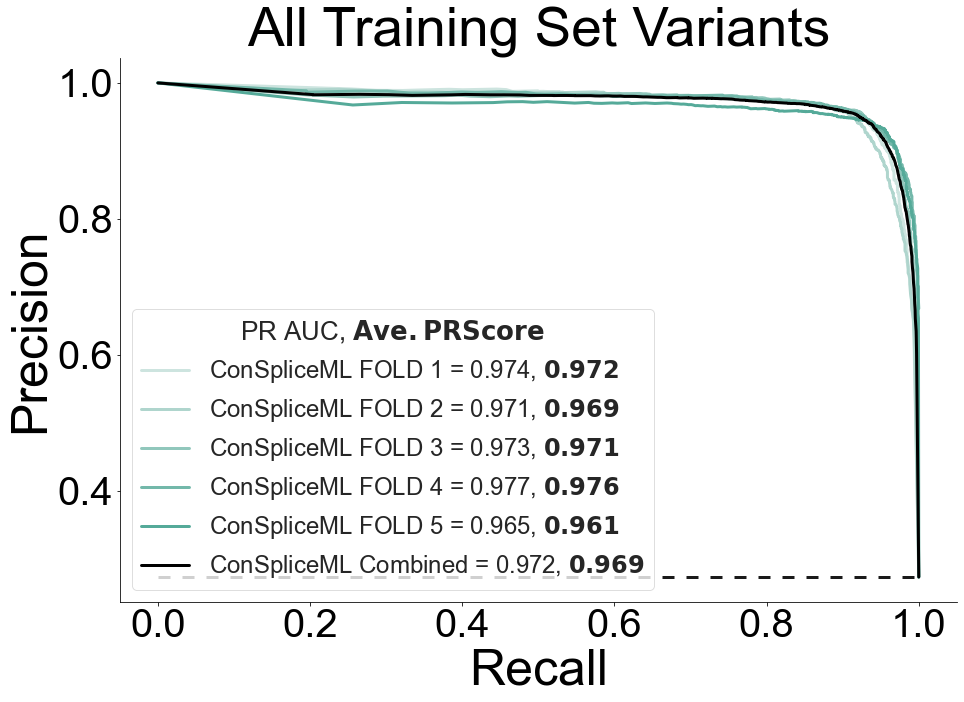

In [29]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df =  pd.concat([patho_test_set.loc[patho_test_set["fold_label"] == i],
                                   benign_test_set.loc[benign_test_set["fold_label"] == i]])
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(scored_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (patho_test_set.shape[0] / (patho_test_set.shape[0] + benign_test_set.shape[0] ))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "All Training Set Variants"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")



plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14_A.svg')



In [30]:
print("C.V. Number of pathogenic variants = {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 11048
C.V. Number of benign variants =     29386


PR AUC=0.928, Avg. Precision Score=0.938
PR AUC=0.961, Avg. Precision Score=0.955
PR AUC=0.932, Avg. Precision Score=0.932
PR AUC=0.971, Avg. Precision Score=0.969


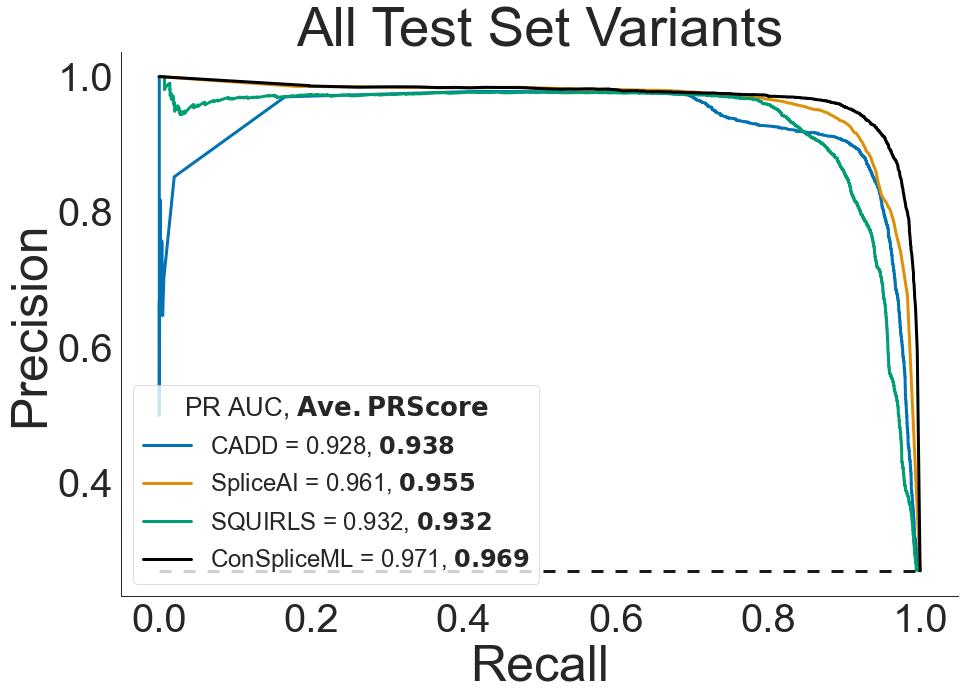

In [31]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(scored_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label": info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] / (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] + scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "All Test Set Variants"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure15.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.001827  0.0-0.1  0.084939    0.001547    0.002158
1    0.394456  0.1-0.2  0.125774    0.308275    0.504731
2    0.943361  0.2-0.3  0.123604    0.740395    1.201965
3    1.391049  0.3-0.4  0.138714    1.059904    1.825653
4    2.182883  0.4-0.5  0.138865    1.662748    2.865723
5    2.687147  0.5-0.6  0.148089    2.010182    3.592091
6    5.020490  0.6-0.7  0.143724    3.787960    6.654062
7    7.632843  0.7-0.8  0.135033    5.857921    9.945558
8   25.712956  0.8-0.9  0.139805   19.550030   33.818674
9  450.337686  0.9-1.0  0.081535  383.826174  528.374679


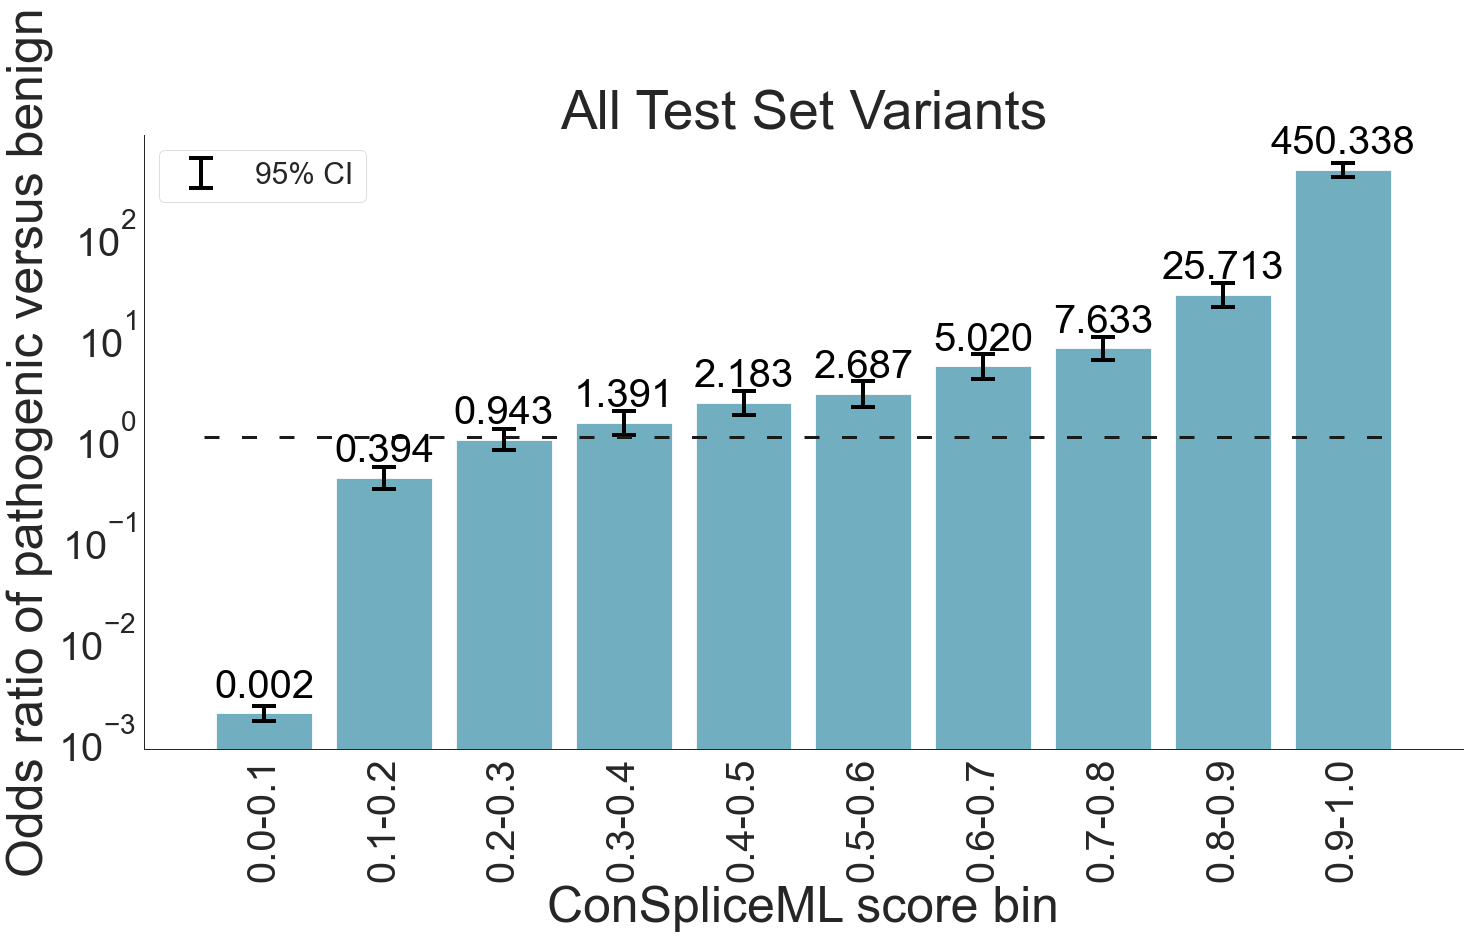

In [32]:
enrichment_df = enrichment_by_bin(scored_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "All Test Set Variants",
                            plot_value_offset = 2.25)

plt.savefig('../figures/figure5_E.svg')

In [33]:
print("TEST: Number of pathogenic variants = {}".format(scored_test_df.loc[scored_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 7269
TEST: Number of benign variants =     19592


In [34]:
non_canonical_combined_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A-1") & (patho_test_set.relative_pos != "A-2") & (patho_test_set.relative_pos != "D+1") & (patho_test_set.relative_pos != "D+2")],benign_test_set.loc[(benign_test_set.relative_pos != "A-1") & (benign_test_set.relative_pos != "A-2") & (benign_test_set.relative_pos != "D+1") & (benign_test_set.relative_pos != "D+2")]])
non_canonical_test_df = scored_test_df.loc[(scored_test_df.relative_pos != "A-1") & (scored_test_df.relative_pos != "A-2") & (scored_test_df.relative_pos != "D+1") & (scored_test_df.relative_pos != "D+2")]


PR AUC=0.867, Avg. Precision Score=0.865
PR AUC=0.854, Avg. Precision Score=0.851
PR AUC=0.877, Avg. Precision Score=0.875
PR AUC=0.894, Avg. Precision Score=0.894
PR AUC=0.877, Avg. Precision Score=0.874
PR AUC=0.873, Avg. Precision Score=0.871


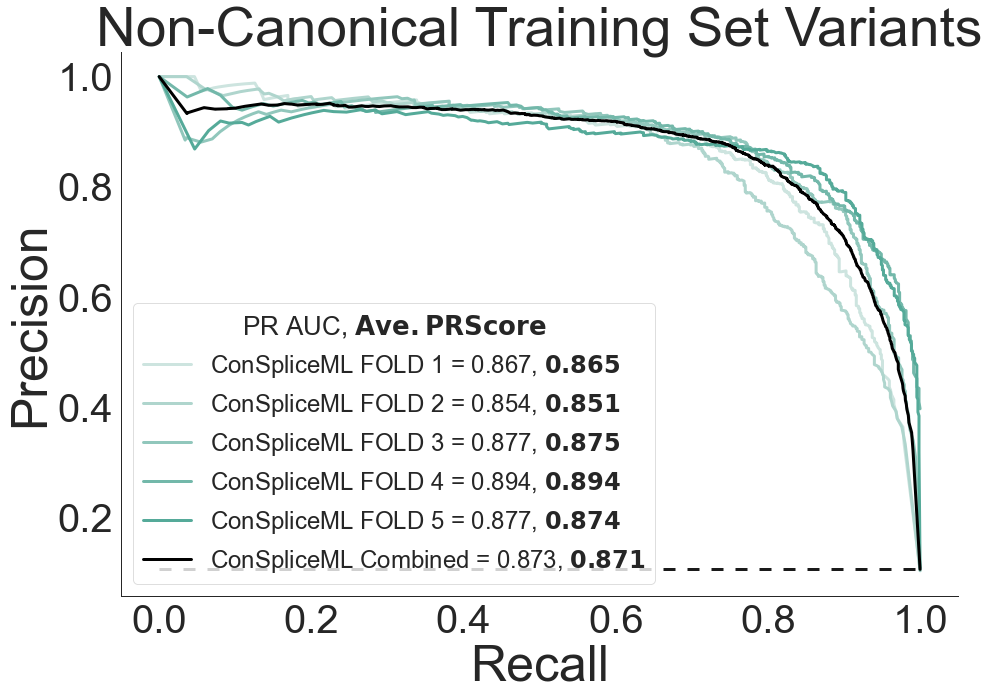

In [35]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_canonical_combined_df.loc[non_canonical_combined_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_canonical_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
               + 
               non_canonical_combined_df[non_canonical_combined_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Non-Canonical Training Set Variants"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")


plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14_B.svg')


In [36]:
print("C.V. Number of pathogenic variants = {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 3422
C.V. Number of benign variants =     29250


PR AUC=0.643, Avg. Precision Score=0.645
PR AUC=0.803, Avg. Precision Score=0.791
PR AUC=0.775, Avg. Precision Score=0.776
PR AUC=0.871, Avg. Precision Score=0.869


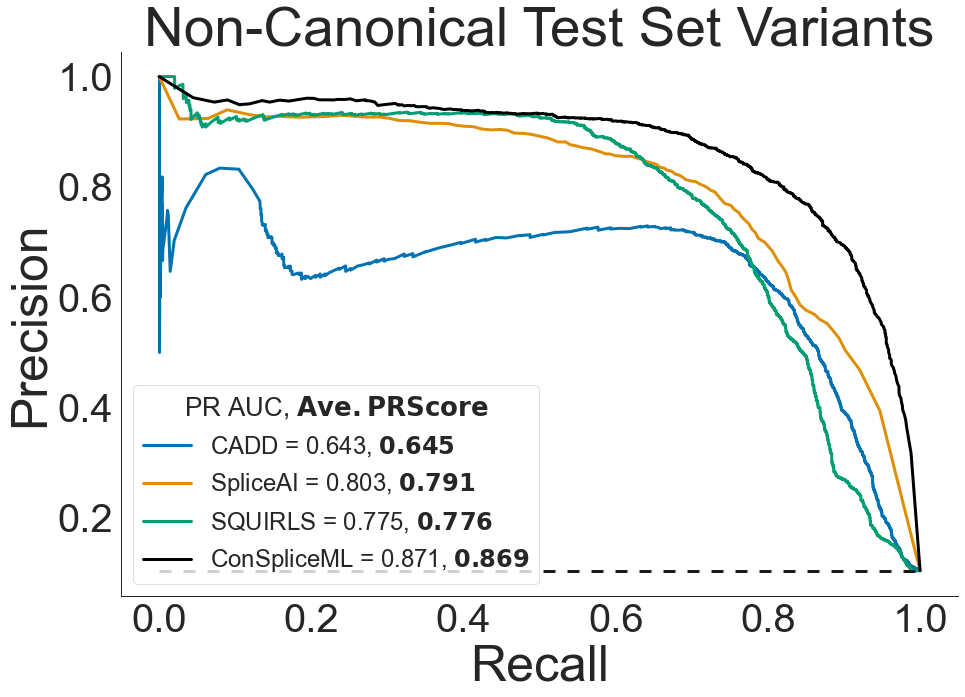

In [37]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_canonical_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
               + 
               non_canonical_test_df[non_canonical_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Non-Canonical Test Set Variants"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_A.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.005688  0.0-0.1  0.087585    0.004791    0.006754
1    1.232228  0.1-0.2  0.129295    0.956386    1.587629
2    2.978405  0.2-0.3  0.126427    2.324702    3.815929
3    4.506405  0.3-0.4  0.140573    3.421152    5.935921
4    6.658323  0.4-0.5  0.143252    5.028357    8.816650
5    7.584153  0.5-0.6  0.155483    5.591878   10.286236
6   13.114659  0.6-0.7  0.153039    9.716009   17.702153
7   17.273696  0.7-0.8  0.145924   12.976934   22.993149
8   51.561531  0.8-0.9  0.150947   38.356344   69.312954
9  223.648107  0.9-1.0  0.110841  179.976237  277.917111


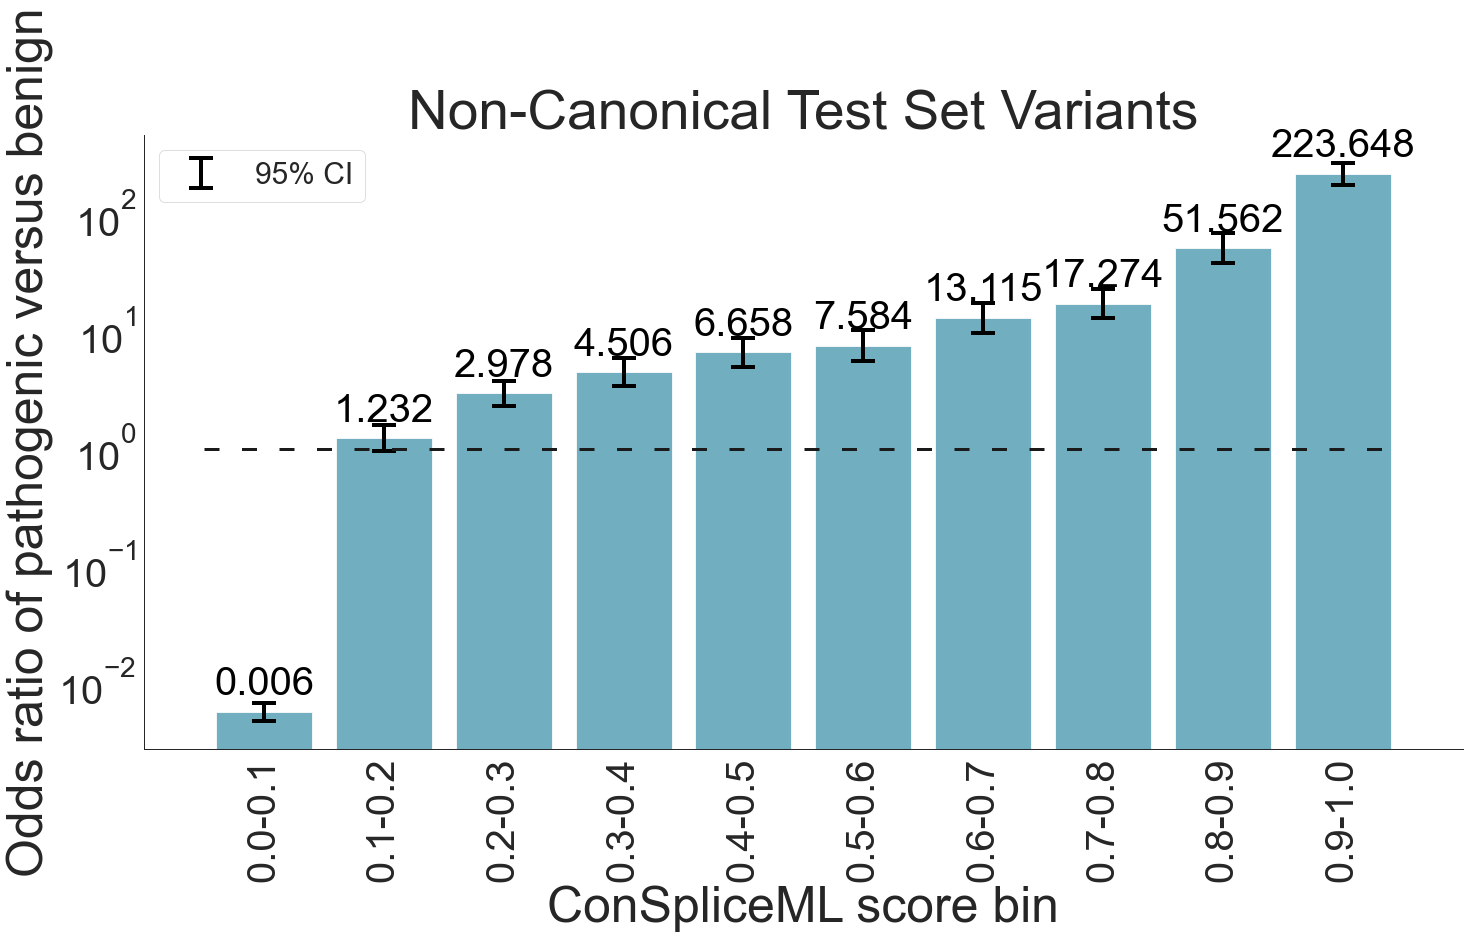

In [38]:
enrichment_df = enrichment_by_bin(non_canonical_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Non-Canonical Test Set Variants",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure16_A.svg')

In [39]:
print("TEST: Number of pathogenic variants = {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 2273
TEST: Number of benign variants =     19499


In [40]:
non_splice_region_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A+3") &
                                                     (patho_test_set.relative_pos != "A+2") & 
                                                     (patho_test_set.relative_pos != "A+1") & 
                                                     (patho_test_set.relative_pos != "A-1") & 
                                                     (patho_test_set.relative_pos != "A-2") & 
                                                     (patho_test_set.relative_pos != "A-3") &
                                                     (patho_test_set.relative_pos != "A-4") & 
                                                     (patho_test_set.relative_pos != "A-5") & 
                                                     (patho_test_set.relative_pos != "A-6") & 
                                                     (patho_test_set.relative_pos != "A-7") & 
                                                     (patho_test_set.relative_pos != "A-8") &
                                                     (patho_test_set.relative_pos != "D-3") & 
                                                     (patho_test_set.relative_pos != "D-2") & 
                                                     (patho_test_set.relative_pos != "D-1") & 
                                                     (patho_test_set.relative_pos != "D+1") & 
                                                     (patho_test_set.relative_pos != "D+2") & 
                                                     (patho_test_set.relative_pos != "D+3") & 
                                                     (patho_test_set.relative_pos != "D+4") & 
                                                     (patho_test_set.relative_pos != "D+5") & 
                                                     (patho_test_set.relative_pos != "D+6") & 
                                                     (patho_test_set.relative_pos != "D+7") & 
                                                     (patho_test_set.relative_pos != "D+8")],
                                 benign_test_set.loc[(benign_test_set.relative_pos != "A+3") &
                                                     (benign_test_set.relative_pos != "A+2") & 
                                                     (benign_test_set.relative_pos != "A+1") & 
                                                     (benign_test_set.relative_pos != "A-1") & 
                                                     (benign_test_set.relative_pos != "A-2") & 
                                                     (benign_test_set.relative_pos != "A-3") &
                                                     (benign_test_set.relative_pos != "A-4") & 
                                                     (benign_test_set.relative_pos != "A-5") & 
                                                     (benign_test_set.relative_pos != "A-6") & 
                                                     (benign_test_set.relative_pos != "A-7") & 
                                                     (benign_test_set.relative_pos != "A-8") &
                                                     (benign_test_set.relative_pos != "D-3") & 
                                                     (benign_test_set.relative_pos != "D-2") & 
                                                     (benign_test_set.relative_pos != "D-1") & 
                                                     (benign_test_set.relative_pos != "D+1") & 
                                                     (benign_test_set.relative_pos != "D+2") & 
                                                     (benign_test_set.relative_pos != "D+3") & 
                                                     (benign_test_set.relative_pos != "D+4") & 
                                                     (benign_test_set.relative_pos != "D+5") & 
                                                     (benign_test_set.relative_pos != "D+6") & 
                                                     (benign_test_set.relative_pos != "D+7") & 
                                                     (benign_test_set.relative_pos != "D+8")]])


non_splice_region_test_df = test_df.loc[(test_df.relative_pos != "A+3") &
                                        (test_df.relative_pos != "A+2") & 
                                        (test_df.relative_pos != "A+1") & 
                                        (test_df.relative_pos != "A-1") & 
                                        (test_df.relative_pos != "A-2") & 
                                        (test_df.relative_pos != "A-3") &
                                        (test_df.relative_pos != "A-4") & 
                                        (test_df.relative_pos != "A-5") & 
                                        (test_df.relative_pos != "A-6") & 
                                        (test_df.relative_pos != "A-7") & 
                                        (test_df.relative_pos != "A-8") &
                                        (test_df.relative_pos != "D-3") & 
                                        (test_df.relative_pos != "D-2") & 
                                        (test_df.relative_pos != "D-1") & 
                                        (test_df.relative_pos != "D+1") & 
                                        (test_df.relative_pos != "D+2") & 
                                        (test_df.relative_pos != "D+3") & 
                                        (test_df.relative_pos != "D+4") & 
                                        (test_df.relative_pos != "D+5") & 
                                        (test_df.relative_pos != "D+6") & 
                                        (test_df.relative_pos != "D+7") & 
                                        (test_df.relative_pos != "D+8")]

PR AUC=0.727, Avg. Precision Score=0.724
PR AUC=0.628, Avg. Precision Score=0.625
PR AUC=0.574, Avg. Precision Score=0.572
PR AUC=0.646, Avg. Precision Score=0.647
PR AUC=0.708, Avg. Precision Score=0.705
PR AUC=0.647, Avg. Precision Score=0.645


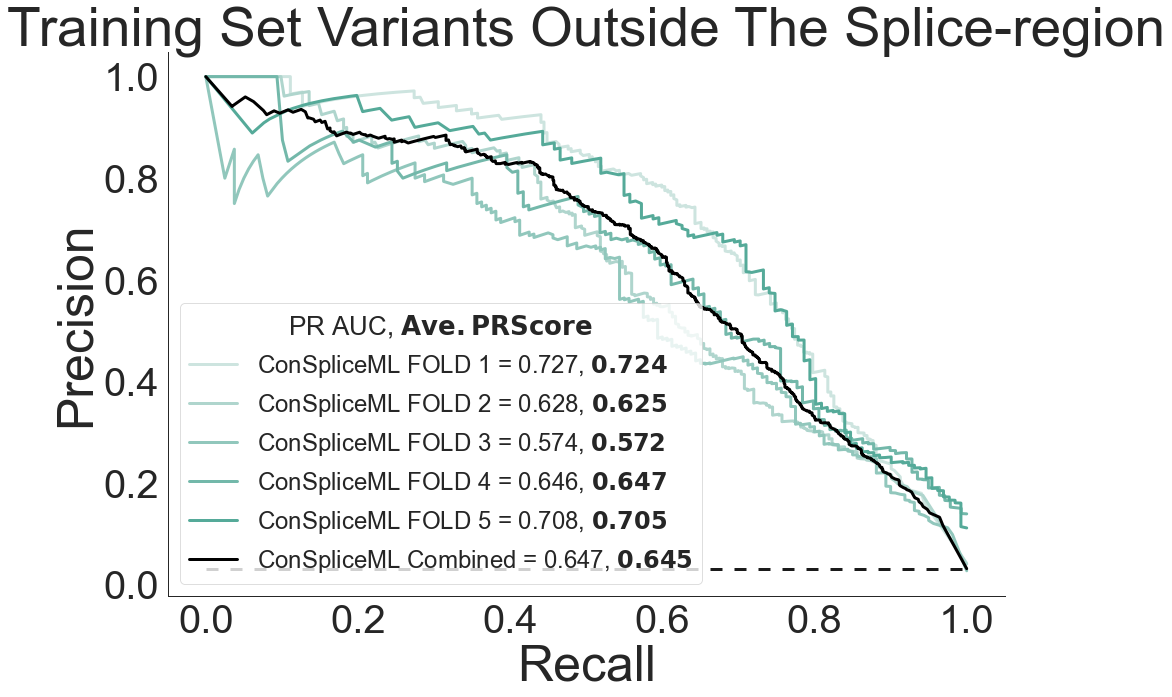

In [41]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_splice_region_df.loc[non_splice_region_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_splice_region_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
              / 
              (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
               + 
               non_splice_region_df[non_splice_region_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Training Set Variants Outside The Splice-region"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14_C.svg')


In [42]:
print("C.V. Number of pathogenic variants = {}".format(non_splice_region_df.loc[non_splice_region_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_splice_region_df.loc[non_splice_region_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 925
C.V. Number of benign variants =     28905


PR AUC=0.222, Avg. Precision Score=0.222
PR AUC=0.572, Avg. Precision Score=0.558
PR AUC=0.466, Avg. Precision Score=0.467
PR AUC=0.621, Avg. Precision Score=0.618


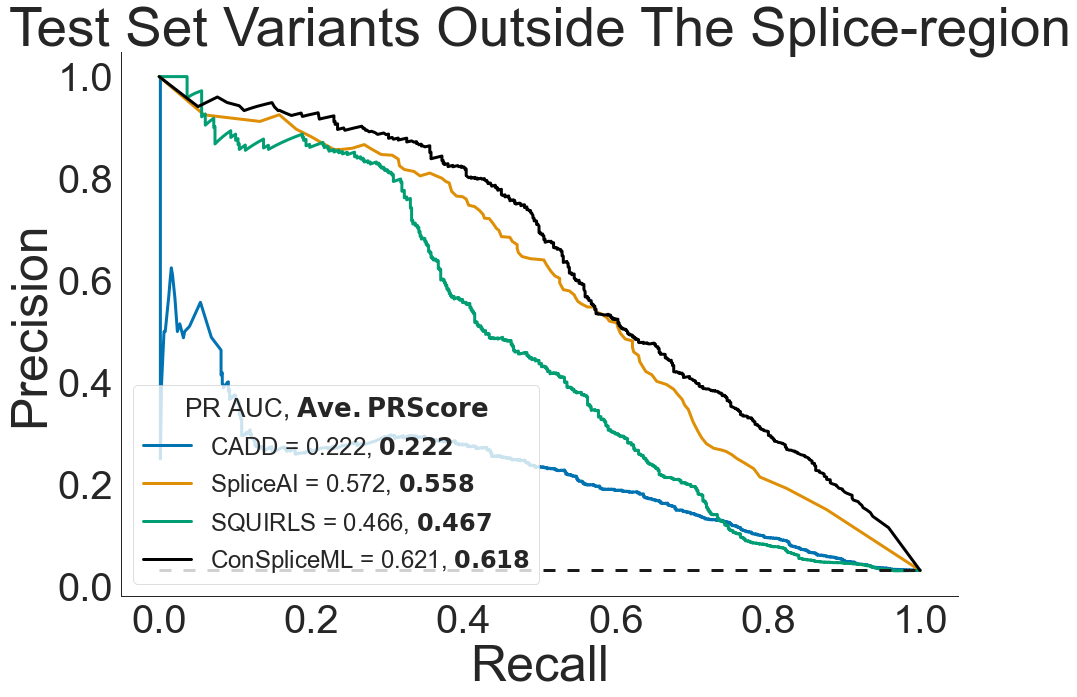

In [43]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_splice_region_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_splice_region_test_df[non_splice_region_test_df.patho_label == 1].shape[0] 
              / 
              (non_splice_region_test_df[non_splice_region_test_df.patho_label == 1].shape[0] 
               + 
               non_splice_region_test_df[non_splice_region_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Test Set Variants Outside The Splice-region"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_B.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.016364  0.0-0.1  0.104961    0.013321    0.020102
1    3.035466  0.1-0.2  0.162343    2.208188    4.172675
2    6.140616  0.2-0.3  0.168720    4.411582    8.547313
3    8.152004  0.3-0.4  0.195061    5.561928   11.948225
4    9.312876  0.4-0.5  0.213245    6.131487   14.144962
5    7.062625  0.5-0.6  0.260515    4.238491   11.768495
6   13.712925  0.6-0.7  0.250216    8.397343   22.393313
7   18.776883  0.7-0.8  0.218012   12.247516   28.787169
8   49.742218  0.8-0.9  0.215600   32.598880   75.901020
9  251.831431  0.9-1.0  0.174683  178.820373  354.652372


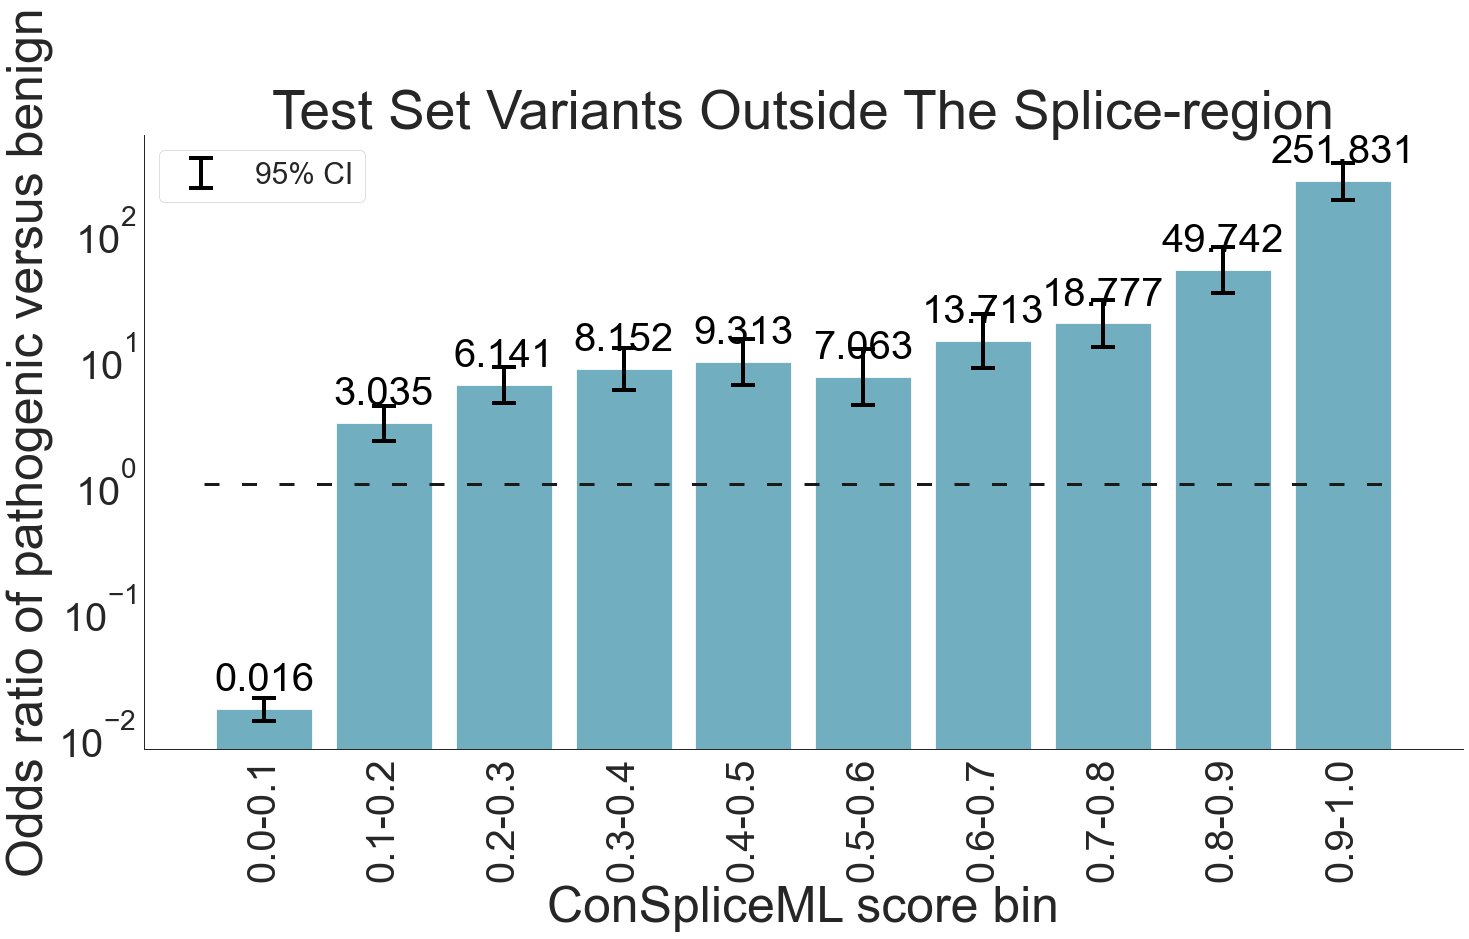

In [44]:
enrichment_df = enrichment_by_bin(non_splice_region_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Test Set Variants Outside The Splice-region",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure16_B.svg')

In [45]:
print("Number of pathogenic variants = {}".format(non_splice_region_test_df.loc[non_splice_region_test_df.patho_label == 1].shape[0]))
print("Number of benign variants =     {}".format(non_splice_region_test_df.loc[non_splice_region_test_df.patho_label == 0].shape[0]))

Number of pathogenic variants = 627
Number of benign variants =     19278


# Variants in the truth set with a SpliceAI score between 0.0 and 0.2

In [46]:
## Get the patho and benign set
patho_test_set = by_fold_scored_df.loc[(by_fold_scored_df.patho_label == 1) & 
                                        (by_fold_scored_df.MAX_SpliceAI >= 0.0) &
                                        (by_fold_scored_df.MAX_SpliceAI < 0.2)]
benign_test_set = by_fold_scored_df.loc[(by_fold_scored_df.patho_label == 0) & 
                                        (by_fold_scored_df.MAX_SpliceAI >= 0.0) &
                                        (by_fold_scored_df.MAX_SpliceAI < 0.2)]

scored_test_df = scored_test_df.loc[(scored_test_df.MAX_SpliceAI >= 0.0) & (scored_test_df.MAX_SpliceAI < 0.2)]

In [47]:
scored_combined_df = pd.concat([patho_test_set,benign_test_set])

PR AUC=0.528, Avg. Precision Score=0.525
PR AUC=0.367, Avg. Precision Score=0.367
PR AUC=0.608, Avg. Precision Score=0.608
PR AUC=0.593, Avg. Precision Score=0.594
PR AUC=0.599, Avg. Precision Score=0.601
PR AUC=0.522, Avg. Precision Score=0.520


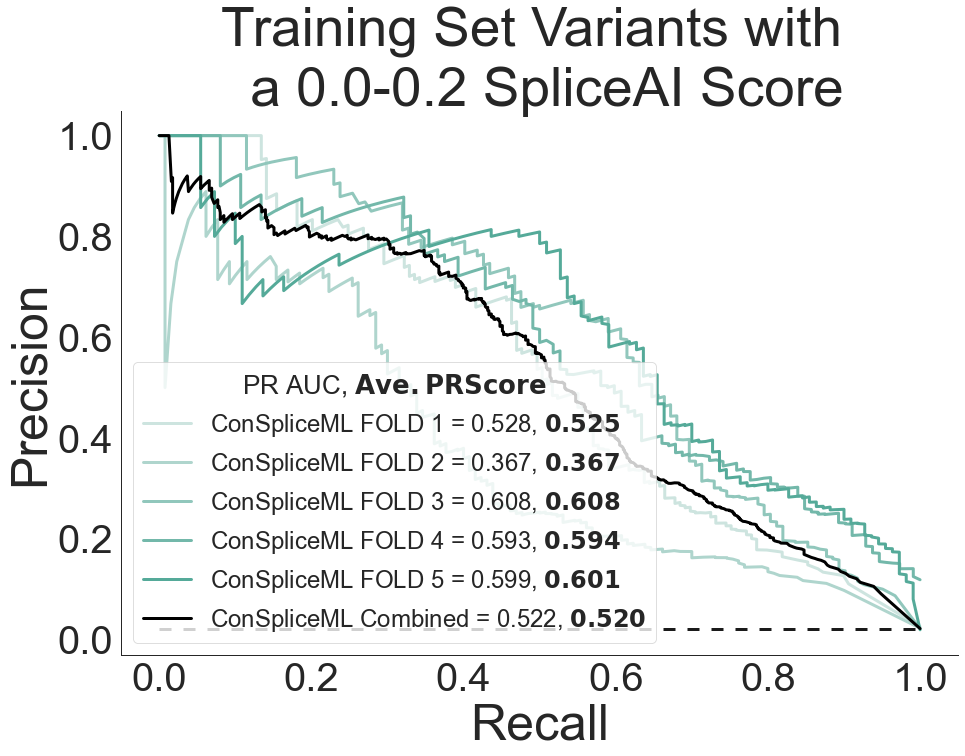

In [48]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df =  pd.concat([patho_test_set.loc[patho_test_set["fold_label"] == i],
                                   benign_test_set.loc[benign_test_set["fold_label"] == i]])
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(scored_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (patho_test_set.shape[0] / (patho_test_set.shape[0] + benign_test_set.shape[0] ))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Training Set Variants with \n a 0.0-0.2 SpliceAI Score"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14_D.svg')


In [49]:
print("C.V. Number of pathogenic variants = {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 623
C.V. Number of benign variants =     28015


PR AUC=0.221, Avg. Precision Score=0.224
PR AUC=0.159, Avg. Precision Score=0.134
PR AUC=0.387, Avg. Precision Score=0.388
PR AUC=0.541, Avg. Precision Score=0.539


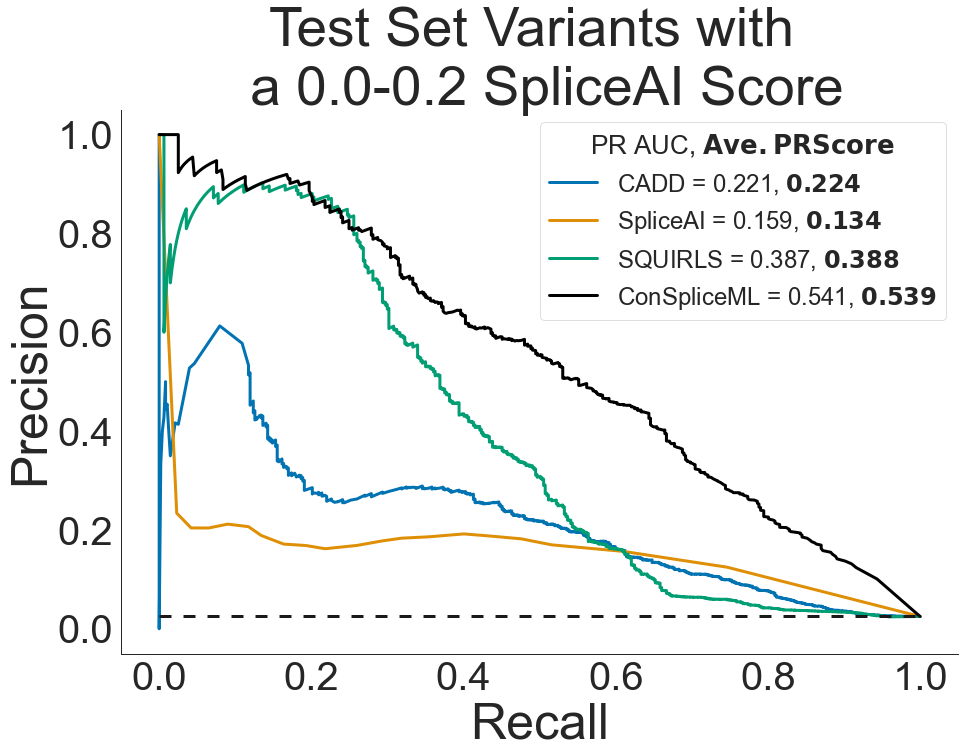

In [50]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(scored_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label": info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] / (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] + scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Test Set Variants with \n a 0.0-0.2 SpliceAI Score"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "upper right")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_C.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.016496  0.0-0.1  0.107836    0.013354    0.020379
1    5.047625  0.1-0.2  0.165885    3.646556    6.987010
2   14.940372  0.2-0.3  0.160384   10.910371   20.458947
3   25.694257  0.3-0.4  0.209883   17.028628   38.769702
4   29.577420  0.4-0.5  0.230666   18.819737   46.484379
5   24.414177  0.5-0.6  0.290320   13.820266   43.128838
6   51.922677  0.6-0.7  0.275484   30.259404   89.095091
7   79.837626  0.7-0.8  0.307645   43.685280  145.908337
8  366.073001  0.8-0.9  0.453536  150.490944  890.481768
9  331.509759  0.9-1.0  0.455738  135.695083  809.894640


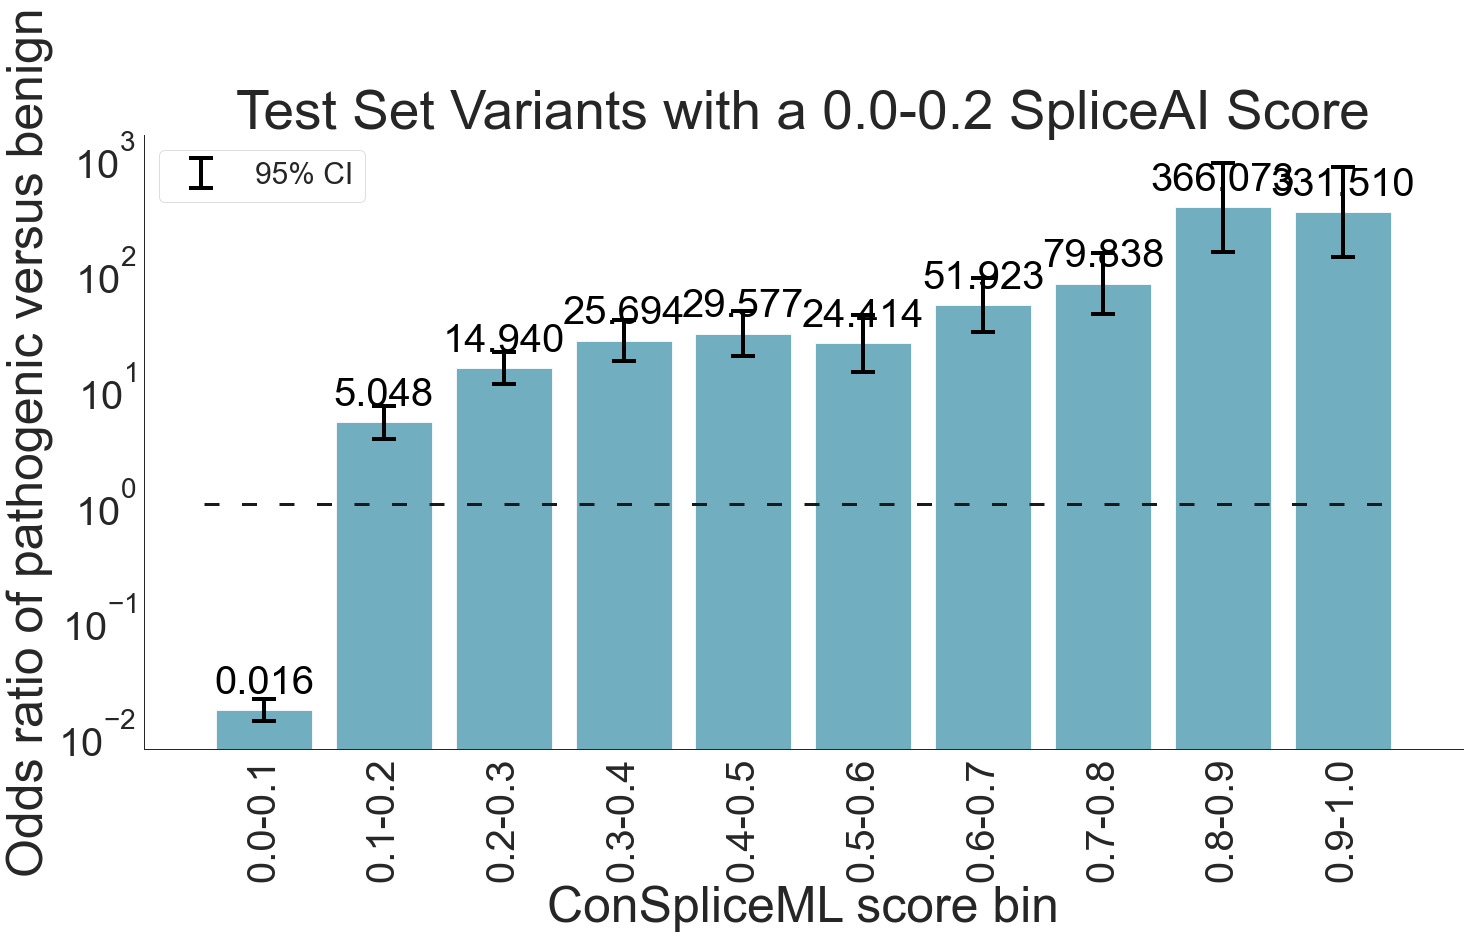

In [51]:
enrichment_df = enrichment_by_bin(scored_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Test Set Variants with a 0.0-0.2 SpliceAI Score",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure16_C.svg')

In [52]:
print("TEST: Number of pathogenic variants = {}".format(scored_test_df.loc[scored_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 477
TEST: Number of benign variants =     18688


In [53]:
non_canonical_combined_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A-1") & (patho_test_set.relative_pos != "A-2") & (patho_test_set.relative_pos != "D+1") & (patho_test_set.relative_pos != "D+2")],benign_test_set.loc[(benign_test_set.relative_pos != "A-1") & (benign_test_set.relative_pos != "A-2") & (benign_test_set.relative_pos != "D+1") & (benign_test_set.relative_pos != "D+2")]])
non_canonical_test_df = scored_test_df.loc[(scored_test_df.relative_pos != "A-1") & (scored_test_df.relative_pos != "A-2") & (scored_test_df.relative_pos != "D+1") & (scored_test_df.relative_pos != "D+2")]


PR AUC=0.503, Avg. Precision Score=0.500
PR AUC=0.339, Avg. Precision Score=0.338
PR AUC=0.586, Avg. Precision Score=0.585
PR AUC=0.593, Avg. Precision Score=0.594
PR AUC=0.587, Avg. Precision Score=0.589
PR AUC=0.504, Avg. Precision Score=0.502


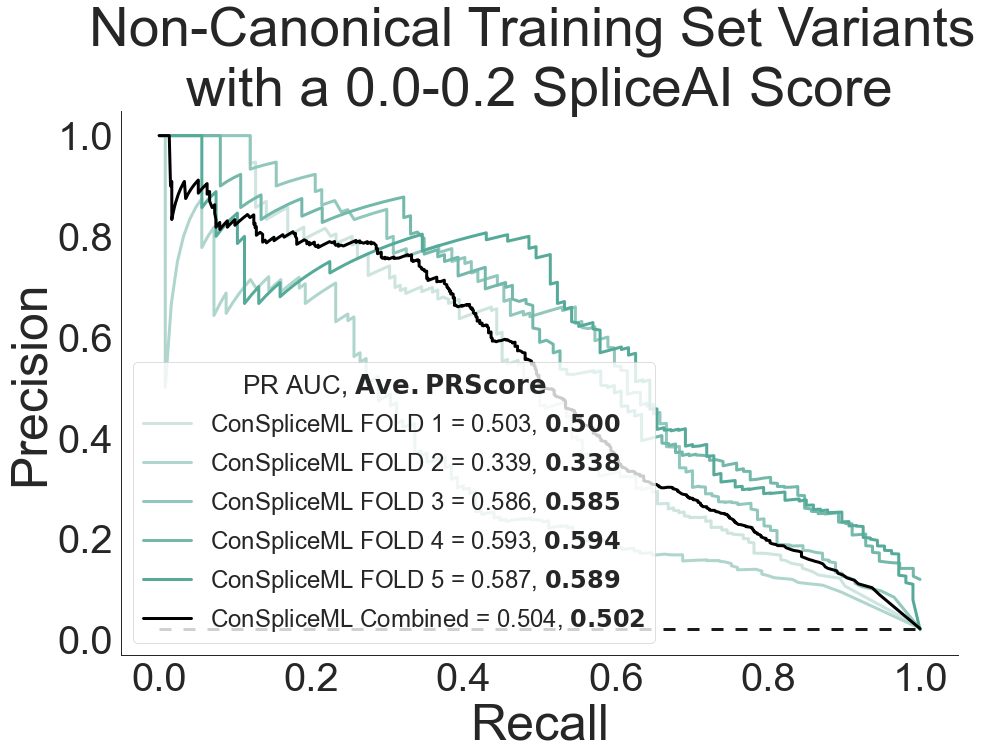

In [54]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_canonical_combined_df.loc[non_canonical_combined_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_canonical_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
               + 
               non_canonical_combined_df[non_canonical_combined_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Non-Canonical Training Set Variants \nwith a 0.0-0.2 SpliceAI Score"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14_E.svg')


In [55]:
print("C.V. Number of pathogenic variants = {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 603
C.V. Number of benign variants =     28009


PR AUC=0.192, Avg. Precision Score=0.194
PR AUC=0.149, Avg. Precision Score=0.124
PR AUC=0.351, Avg. Precision Score=0.351
PR AUC=0.511, Avg. Precision Score=0.509


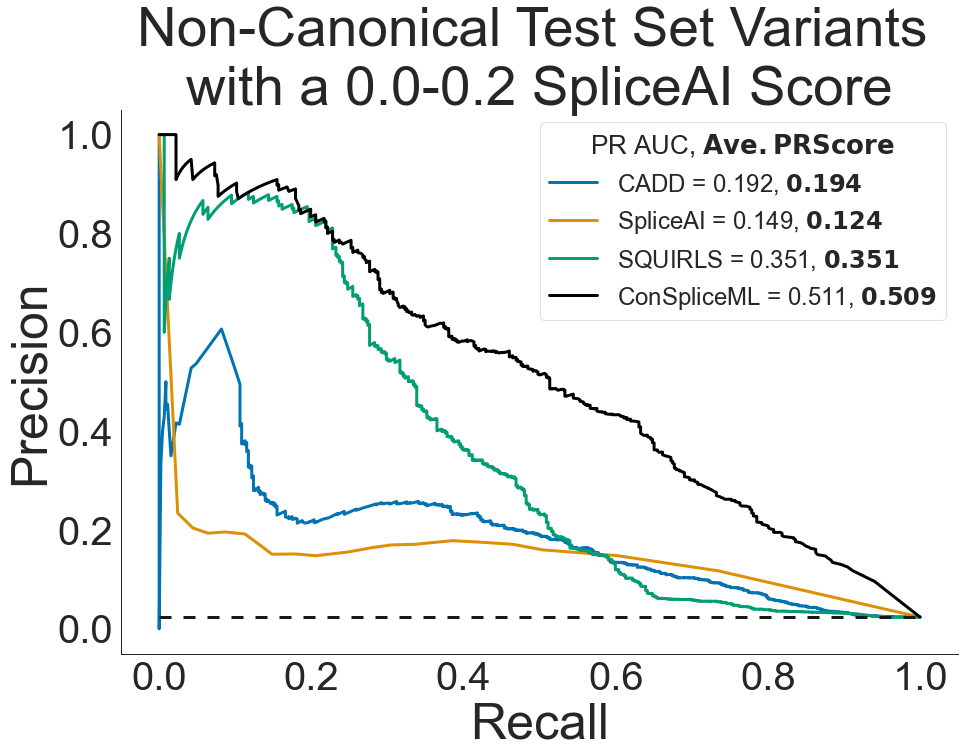

In [56]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_canonical_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
               + 
               non_canonical_test_df[non_canonical_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Non-Canonical Test Set Variants \nwith a 0.0-0.2 SpliceAI Score"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "upper right")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_D.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.017595  0.0-0.1  0.109117    0.014207    0.021791
1    5.104295  0.1-0.2  0.169446    3.661851    7.114933
2   15.567465  0.2-0.3  0.161787   11.337111   21.376343
3   27.241046  0.3-0.4  0.210210   18.042192   41.129956
4   30.328994  0.4-0.5  0.232924   19.212727   47.877008
5   25.819377  0.5-0.6  0.290537   14.609514   45.630557
6   47.329354  0.6-0.7  0.284518   27.098426   82.664127
7   70.307045  0.7-0.8  0.317396   37.742097  130.969949
8  333.487934  0.8-0.9  0.457151  136.127254  816.987041
9  306.555628  0.9-1.0  0.459288  124.610828  754.158808


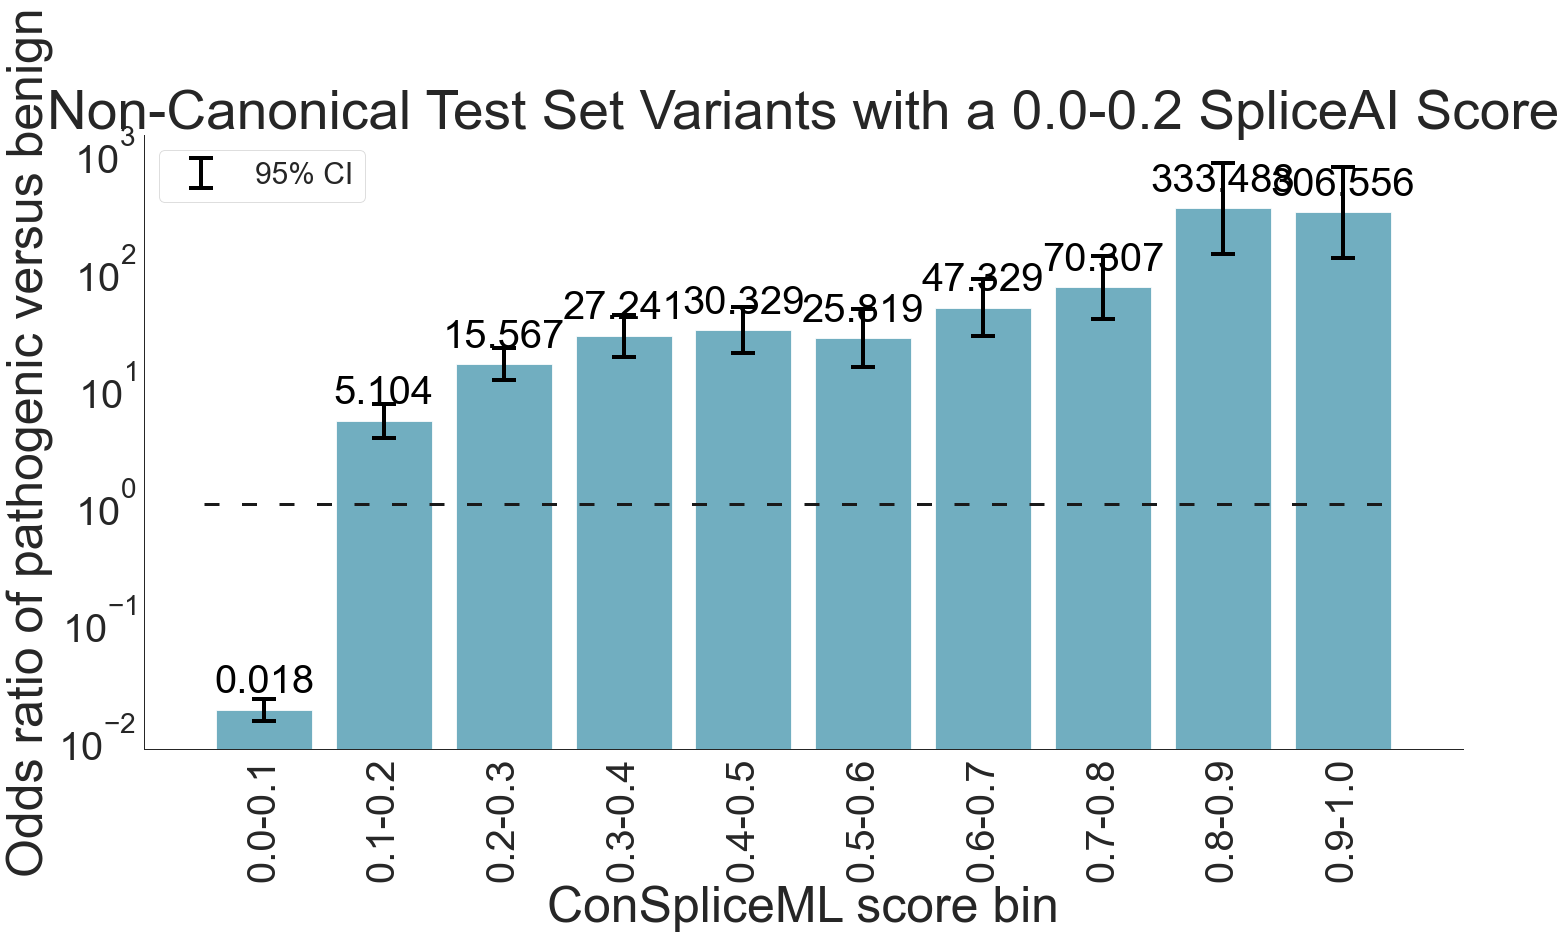

In [57]:
enrichment_df = enrichment_by_bin(non_canonical_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Non-Canonical Test Set Variants with a 0.0-0.2 SpliceAI Score",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure16_D.svg')

In [58]:
print("TEST: Number of pathogenic variants = {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 452
TEST: Number of benign variants =     18686
